<a href="https://colab.research.google.com/github/HKLeeeee/AI_proj_Team2/blob/main/Hyper_parameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import cv2

# from tensorflow.keras.applications import Densnet
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow.keras as keras
from tensorflow.data import Dataset

from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from itertools import product
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2022-05-13 23:09:17.391706: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
from tensorflow.keras.applications import *

# Data Load

- PREPROCESSING ~~ : dacon 코드 공유 기반으로 저장한 512X512 이미지들


In [3]:
## 경로 설정
small_train_images_path = './data/PREPROCESSING-TRAIN'
small_test_images_path = './data/PREPROCESSING-TEST'
data_path = './data'

- *_images_name : 이미지 파일들 이름
- *_images_path : 이미지 파일 경로

In [4]:
train_images_name = sorted(os.listdir(small_train_images_path))
train_images_path = \
[os.path.join(small_train_images_path, name) for name in train_images_name]

test_images_name = sorted(os.listdir(small_test_images_path))
test_images_path = \
[os.path.join(small_test_images_path, name) for name in test_images_name]

In [5]:
train_images_name[0]

'CASE01_01.png'

In [6]:
train_images_path[0]

'./data/PREPROCESSING-TRAIN/CASE01_01.png'

label 불러오기

In [7]:
label_dfs = []
case_names = sorted(os.listdir('./data/train'))

for case in case_names :
    label_path = data_path+'/train/'+case+'/label-{}.csv'.format(str(int(case[-2:])))
    df = pd.read_csv(label_path)
    label_dfs.append(df)
    
label_df = pd.concat(label_dfs, axis=0)
label_df.to_csv('./data/labels.csv', index=False)

data 순서 shuffle

In [8]:
label_df.set_index('img_name', inplace=True)
label_df.head()

,leaf_weight
img_name,
CASE01_01.png,49.193
CASE01_02.png,59.764
CASE01_03.png,72.209
CASE01_04.png,85.737
CASE01_05.png,102.537


In [9]:
label_df['img_path'] = train_images_path
label_df.head()

,leaf_weight,img_path
img_name,,
CASE01_01.png,49.193,./data/PREPROCESSING-TRAIN/CASE01_01.png
CASE01_02.png,59.764,./data/PREPROCESSING-TRAIN/CASE01_02.png
CASE01_03.png,72.209,./data/PREPROCESSING-TRAIN/CASE01_03.png
CASE01_04.png,85.737,./data/PREPROCESSING-TRAIN/CASE01_04.png
CASE01_05.png,102.537,./data/PREPROCESSING-TRAIN/CASE01_05.png


In [10]:
shuffled_df = label_df.sample(frac=1)
shuffled_df.head()

,leaf_weight,img_path
img_name,,
CASE14_05.png,0.480,./data/PREPROCESSING-TRAIN/CASE14_05.png
CASE14_33.png,45.472,./data/PREPROCESSING-TRAIN/CASE14_33.png
CASE37_23.png,276.781,./data/PREPROCESSING-TRAIN/CASE37_23.png
CASE69_04.png,1.924,./data/PREPROCESSING-TRAIN/CASE69_04.png
CASE73_25.png,88.145,./data/PREPROCESSING-TRAIN/CASE73_25.png


In [11]:
len(shuffled_df)

1592

# Data Generator

In [12]:
# Train : Validation = 0.8 : 0.2 Split
train_len = int(len(shuffled_df)*0.8)

train_df = shuffled_df[:train_len]
valid_df = shuffled_df[train_len:]

train_img_path = train_df['img_path'].to_list()
train_label = train_df['leaf_weight'].to_list()

valid_img_path = valid_df['img_path'].to_list()
valid_label = valid_df['leaf_weight'].to_list()

In [13]:
train_df

,leaf_weight,img_path
img_name,,
CASE14_05.png,0.480,./data/PREPROCESSING-TRAIN/CASE14_05.png
CASE14_33.png,45.472,./data/PREPROCESSING-TRAIN/CASE14_33.png
CASE37_23.png,276.781,./data/PREPROCESSING-TRAIN/CASE37_23.png
CASE69_04.png,1.924,./data/PREPROCESSING-TRAIN/CASE69_04.png
CASE73_25.png,88.145,./data/PREPROCESSING-TRAIN/CASE73_25.png
...,...,...
CASE61_21.png,79.222,./data/PREPROCESSING-TRAIN/CASE61_21.png
CASE61_28.png,204.018,./data/PREPROCESSING-TRAIN/CASE61_28.png
CASE58_20.png,141.866,./data/PREPROCESSING-TRAIN/CASE58_20.png


In [14]:
%%time
train_img = np.array(list(map(cv2.imread, train_img_path)))
valid_img = np.array(list(map(cv2.imread, valid_img_path)))

CPU times: user 8.68 s, sys: 792 ms, total: 9.48 s
Wall time: 9.48 s


In [15]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                 rotation_range=10,
                                 shear_range=0.1,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode = 'nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
BATCH_SIZE = 19

train_generator = train_datagen.flow(train_img,
                                    train_label,
                                    batch_size=BATCH_SIZE)

valid_generator = test_datagen.flow(valid_img,
                                    valid_label,
                                   batch_size=BATCH_SIZE)

Labels:  [1.953, 10.727, 260.569, 47.745, 52.281]


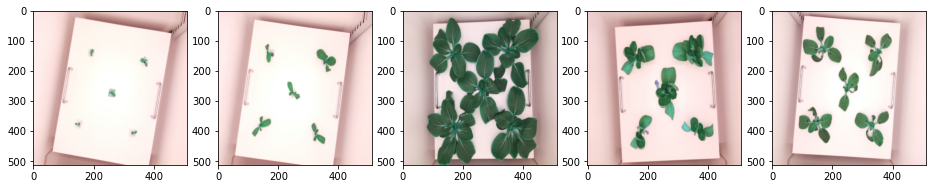

In [17]:
test = [next(train_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16,6))

print('Labels: ', [item[1][0] for item in test])
l = [ax[i].imshow(test[i][0][0]) for i in range(0,5)]

Labels:  [0.745, 18.281, 25.733, 33.408, 182.016]


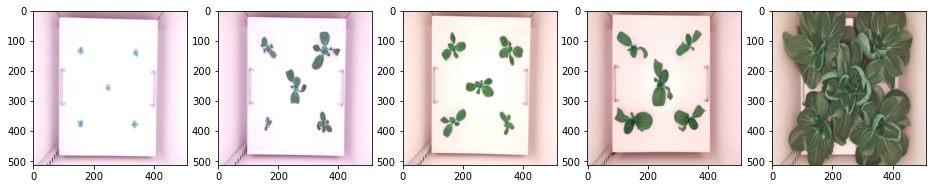

In [18]:
test = [next(valid_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16,6))

print('Labels: ', [item[1][0] for item in test])
l = [ax[i].imshow(test[i][0][0]) for i in range(0,5)]

# Definitions

In [19]:
def NMAE(y_true, y_pred) :
    error = y_true - y_pred
    absolute_error = tf.abs(error)
    return tf.reduce_mean(absolute_error) / tf.reduce_mean(y_true)

In [20]:
def nmae(y_true, y_pred):
    score = tf.py_function(func=NMAE, inp=[y_true, y_pred], Tout=tf.float32, name='nmae')
    return score

In [21]:
IMAGE_SIZE = 512
def bulid_model(hyper_params : tuple) :
    pretrain_net, learning_rate, opti, dropout = hyper_params

    if pretrain_net == 'resnet50' :
        MODEL_IMAGE_SIZE = 224
        base_model = resnet50.ResNet50(
        weights='imagenet',
        include_top = False,
        input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3)
        )
    elif pretrain_net == 'inception_v2_resnet':
        MODEL_IMAGE_SIZE = 299
        base_model = inception_resnet_v2.InceptionResNetV2(
            weights='imagenet',
            include_top = False,
            input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3)
        )

    base_model.trainable=False

    input_data = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
    x = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data)
    resizing = Model(inputs=input_data, outputs=x, name='resize')

    inputs = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
    x = resizing(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout)(x)
    x = Dense(1024, activation='relu')(x)
    outputs = Dense(1, activation='relu')(x)
    model = Model(inputs, outputs)

    optimizer = None 
    if opti == 'adam' :
        optimizer = Adam(learning_rate)
    elif opti == 'rmsprop' :
        optimizer = RMSprop(learning_rate)
    elif opti == 'nadam' :
        optimizer = Nadam(learning_rate)


    model.compile(optimizer=optimizer,
                loss='mae',
                metrics=[nmae])

    return model

In [22]:
def fit_model(model=None, early_stop = True, epoch=100, ckpt_path=None, save_best_only=True, 
              save_weights_only=True) :
    es = EarlyStopping(monitor='loss',
                    mode='auto',
                    patience=5,
                    verbose=1)

    checkpointer = ModelCheckpoint(filepath=ckpt_path,
                                  monitor='val_nmae',
                                  save_weights_only = save_weights_only,
                                  save_best_only= save_best_only,
                                  verbose=1)

    call_backs = [checkpointer]
    if early_stop :
        call_backs.append(es)

    STEPS_PER_EPOCH = len(train_img) // BATCH_SIZE
    VAL_STEPS = len(valid_img) // BATCH_SIZE
    history = model.fit(train_generator, epochs=epoch,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=valid_generator,
                      validation_steps = VAL_STEPS,
                      callbacks=call_backs,
                      verbose=1)
    return history

In [23]:
def draw_graph(title) :
    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.legend(loc='upper right')
    ax1.set_title('MAE : '+title)
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(history.history['nmae'], label='Training NMAE')
    ax2.plot(history.history['val_nmae'], label='Validation NMAE')
    ax2.legend(loc='upper right')
    ax2.set_title('NMAE : '+title)
    
    plt.savefig('./Training_Result/'+title+'.png')  ## 그래프 이미지 저장 경로
    plt.show()

# Parameters

In [24]:
PARAMS = {
    'pretrain_net' : ['resnet50', 'inception_v2_resnet'], 
    'learning rate' : [1e-2, 1e-3, 1e-4, 1e-5],
    'optimizer' : ['adam', 'rmsprop', 'nadam'],
    'dropout' : [0.2, 0.5]
}

In [25]:
hyper_params=list(product(PARAMS['pretrain_net'], PARAMS['learning rate'],PARAMS['optimizer'],PARAMS['dropout']))

# Train

In [26]:
history_dict = {'min_nmae' : 9999,
                'min_nmae_param' : '',
                'min_val_nmae' : 9999,
                'min_val_nmae_param' : '',
                'min_mae' : 9999,
                'min_mae_param' : '',
                'min_val_mae' : 9999,
                'min_val_mae_param' : ''}

2022-05-13 23:09:35.227651: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-13 23:09:35.228621: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-13 23:09:35.284881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 23:09:35.285467: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-05-13 23:09:35.285494: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-13 23:09:35.287051: I tensorflow/stream_executor/platform/default/dso_loade

Epoch 1/2


2022-05-13 23:09:40.765185: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-13 23:09:41.699625: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


67/67 [==============================] - 68s 955ms/step - loss: 56.8959 - nmae: 0.6907 - val_loss: 42.9372 - val_nmae: 0.5480

Epoch 00001: val_nmae improved from inf to 0.54798, saving model to ./Check_Point/resnet50 0.01 adam 0.2-best_weights.ckpt
Epoch 2/2
67/67 [==============================] - 64s 951ms/step - loss: 43.5959 - nmae: 0.5275 - val_loss: 47.1477 - val_nmae: 0.6039

Epoch 00002: val_nmae did not improve from 0.54798


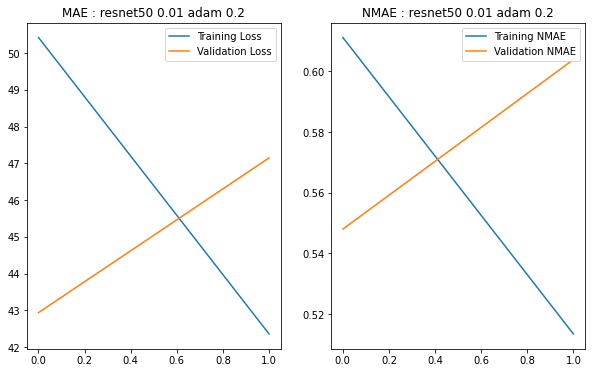

Epoch 1/2
27/67 [===========>..................] - ETA: 36s - loss: 56.7368 - nmae: 0.7980

In [ ]:
i=0
for params in hyper_params :
    tf.keras.backend.clear_session()
    key = ' '.join(map(str, params))
    model = bulid_model(params)
    history = fit_model(model=model,
                      epoch=2,
                      ckpt_path='./Check_Point/{}-best_weights.ckpt'.format(key))  #### 체크포인트 저장 경로
    if min(history.history['nmae']) < history_dict['min_nmae'] :
        history_dict['min_nmae'] = min(history.history['nmae'])
        history_dict['min_nmae_param'] = key

    if min(history.history['val_nmae']) < history_dict['min_val_nmae'] :
        history_dict['min_val_nmae'] = min(history.history['val_nmae'])
        history_dict['min_val_nmae_param'] = key
    
    if min(history.history['loss']) < history_dict['min_mae'] :
        history_dict['min_mae'] = min(history.history['loss'])
        history_dict['min_mae_param'] = key

    if min(history.history['val_loss']) < history_dict['min_val_mae'] :
        history_dict['min_val_mae'] = min(history.history['val_loss'])
        history_dict['min_val_mae_param'] = key
    draw_graph(key)
    i+=1
    if i==2 :
        break

In [ ]:
history_dict